[*********************100%***********************]  1 of 1 completed

Epoch 1/100



C:\Users\gauta\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0145
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6046e-04
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5611e-04
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8730e-04
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7104e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7799e-04
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1257e-04
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8572e-04
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3025e-04
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3110e-04
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4656e-04
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2974e-04
Epoch 13/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9371e-04
Epoch 14/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9452e-04
Epoch 15/100
72/7

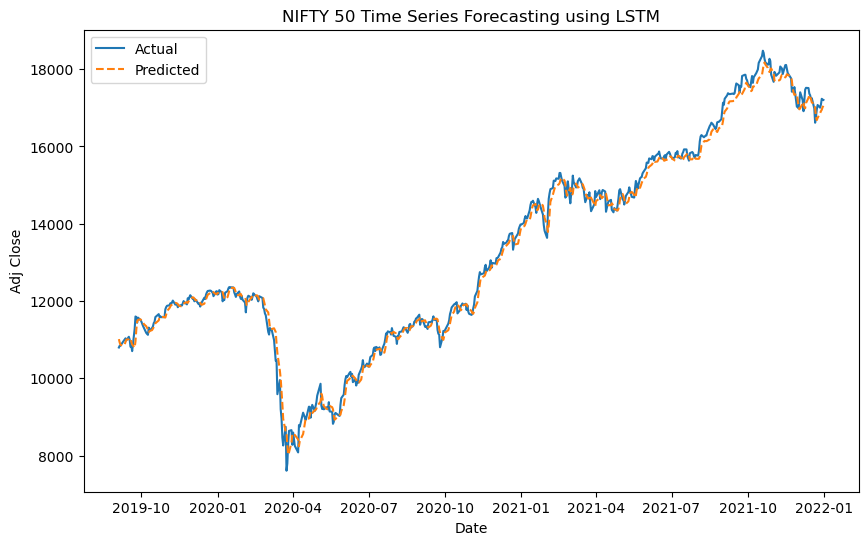

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Download historical NIFTY 50 data using yfinance
nifty_data = yf.download("^NSEI", start='2010-01-01', end="2022-01-01")

# Check if data is downloaded correctly
if nifty_data.empty:
    raise ValueError("Failed to download data. Check ticker symbol and internet connection.")

# Extract relevant columns
nifty_data = nifty_data[['Adj Close']]

# Reset the index to make Date a column
nifty_data = nifty_data.reset_index()

# Convert "Date" column to datetime format if needed
if not pd.api.types.is_datetime64_any_dtype(nifty_data['Date']):
    nifty_data['Date'] = pd.to_datetime(nifty_data['Date'])

# Feature engineering: Adding a column for days since the start
nifty_data['Days'] = (nifty_data['Date'] - nifty_data['Date'].min()).dt.days

# Normalize the "Adj Close" prices for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
nifty_data['Adj Close'] = scaler.fit_transform(nifty_data[['Adj Close']])

# Prepare data for LSTM model (time series windowing)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (number of previous days to use for prediction)
time_step = 60

# Create LSTM data (features and target)
X, y = create_dataset(nifty_data[['Adj Close']].values, time_step)

# Reshape input data to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predicted values and actual test values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(nifty_data['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(nifty_data['Date'][-len(y_test):], y_pred, label='Predicted', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('NIFTY 50 Time Series Forecasting using LSTM')
plt.legend()
plt.show()
